Lectura de insumos obtenidos a partir de las transformaciones aplicadas en el notebook *02_data_transformation*

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [44]:
# You can safely assume that `build_dataset` is correctly implemented
def build_dataset():
    data = [json.loads(x) for x in open("../data/MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

In [46]:
X_train, y_train, X_test, y_test = build_dataset()
del(X_train,X_test)

In [47]:
df_X_train_processed = pd.read_csv("X_train_processed.csv")
df_X_test_processed = pd.read_csv("X_test_processed.csv")

## MODELOS

In [7]:
#pip install xgboost

In [29]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [30]:
y_train_transform = [int(x == "used") for x in y_train]
y_test_transform = [int(x == "used") for x in y_test]

## XGBoost

### Test 
para dar una idea del desempeño del modelo, se ejecuta el modelo estandar. 

- En este se evidencia que la variable **score_seller** tiene una importancia mayor al 70% por lo que esta variable tendría demasiada significancia en el modelo, se decide eliminar esta variable del analisis para asi poder encontrar relaciones que generalicen mejor el problema

- Cuando se elimina la variable **score_seller** las metricas del modelo mejoran, dando un puntaje de 0.87

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

In [36]:
test = GradientBoostingClassifier()
test.fit(df_X_train_processed, y_train_transform)
y_pred = test.predict(df_X_test_processed)
acc = accuracy_score(y_test_transform, y_pred)
print("accuracy score: {}".format(acc))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8212


,Feature,Importance
32,score_seller,0.958650
1,listing_type_id,0.024443
33,score_popularity_category,0.014779
8,initial_quantity,0.000757
2,price,0.000591
30,num_pictures,0.000234
34,score_category_id,0.000157
9,sold_quantity,0.000145
3,parent_item_id,0.000135
37,flg_outliers_sold_quantity,0.000071


In [37]:
test = XGBClassifier()
test.fit(df_X_train_processed, y_train_transform)
y_pred = test.predict(df_X_test_processed)
acc = accuracy_score(y_test_transform, y_pred)
print("accuracy score: {}".format(acc))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8215


,Feature,Importance
32,score_seller,0.728126
1,listing_type_id,0.138286
33,score_popularity_category,0.017690
8,initial_quantity,0.011853
3,parent_item_id,0.010928
9,sold_quantity,0.009680
29,num_tags,0.007024
30,num_pictures,0.006498
10,shipping_local_pick_up,0.006111
2,price,0.005881


In [38]:
test = XGBClassifier()
test.fit(df_X_train_processed.drop(columns="score_seller"), y_train_transform)
y_pred = test.predict(df_X_test_processed.drop(columns="score_seller"))
acc = accuracy_score(y_test_transform, y_pred)
print("accuracy score: {}".format(acc))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns="score_seller").columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8721


,Feature,Importance
32,score_popularity_category,0.252605
1,listing_type_id,0.231821
8,initial_quantity,0.128012
11,shipping_free_shipping,0.049634
12,shipping_free_methods,0.049149
9,sold_quantity,0.028372
20,MercadoPago,0.021770
0,warranty,0.019586
25,tarjeta_credito,0.017856
29,num_tags,0.016211


# Fine tunning

# Manual
para evitar la comparacion de combinaciones no deseadas o de bajo desempeño primero se realiza un tunning manual, iterando por cada variable considerada en el siguiente orden

1. learning_rate
2. max_depth
3. n_estimators
4. reg_lambda, reg_alpha (regularizadores L2, L1)

max value roc 0.8727554607652278
max arg roc 0.27
max value acc 0.8741
max arg acc 0.76


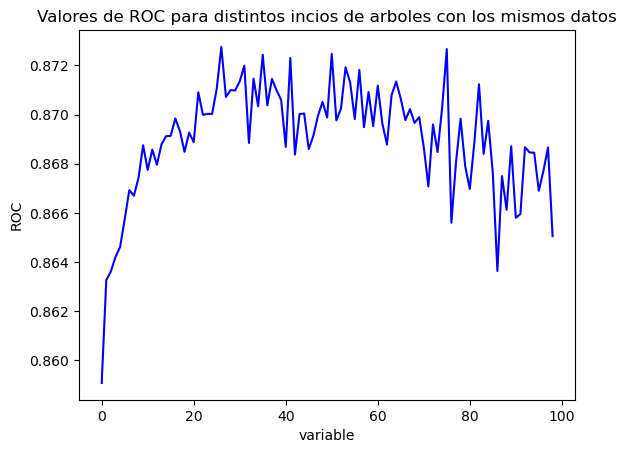

In [39]:
roc_arr = []
acc_arr = []

learning_rate = np.arange(0.01,1,0.01)
max_depth = np.arange(1,10,1)
#n_estimators = np.arange(50,400,50)
n_estimators = np.arange(80,110,1)
lambda_values = [0.01,0.1,0,1,10,100]
alpha_values = [0.01,0.1,0,1,10,100]
lambda_values = np.arange(0,2,1)
alpha_values = np.arange(0,2,1)



#values = [(l, a) for l in lambda_values for a in alpha_values]
values = learning_rate

for n in values:
    # print(n)

    #xg = XGBClassifier(learning_rate=0.62, max_depth = 6, n_estimators=99,reg_lambda = n[0], reg_alpha= n[1])
    xg = XGBClassifier(learning_rate=n)
    xg.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)
    #y_pred = xg.predict_proba(df_X_test)
    y_pred = xg.predict(df_X_test_processed.drop(columns=["score_seller"]))

    roc = roc_auc_score(y_test_transform, y_pred, average='macro')
    acc = accuracy_score(y_test_transform, y_pred)
    roc_arr.append(roc)
    acc_arr.append(acc)


print("max value roc {}".format(roc_arr[np.argmax(roc_arr)]))
print("max arg roc {}".format(values[np.argmax(roc_arr)]))

print("max value acc {}".format(acc_arr[np.argmax(acc_arr)]))
print("max arg acc {}".format(values[np.argmax(acc_arr)]))

plt.title('Valores de ROC para distintos incios de arboles con los mismos datos')
plt.plot(np.arange(0,len(values)), roc_arr, 'b',)
plt.ylabel('ROC')
plt.xlabel('variable')
plt.show()

In [40]:
learning_rate = np.arange(0.41,0.71,0.1)
max_depth = np.arange(2,8,2)
n_estimators = np.arange(94,106,2)
lambda_values = np.arange(0,2,1)
alpha_values = np.arange(0,2,1)

parameters = {"n_estimators":n_estimators, 
              "max_depth":max_depth,
              "learning_rate":learning_rate,
              "reg_lambda": lambda_values,
              "reg_alpha":alpha_values
              }

clf = GridSearchCV(XGBClassifier(), parameters, verbose = 3)
clf.fit(df_X_train_processed.drop(columns=["score_seller"]),y_train_transform)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.903 total time=   0.1s
[CV 2/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.905 total time=   0.1s
[CV 3/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.903 total time=   0.1s
[CV 4/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.909 total time=   0.1s
[CV 5/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=0;, score=0.905 total time=   0.1s
[CV 1/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=1;, score=0.904 total time=   0.1s
[CV 2/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_lambda=1;, score=0.906 total time=   0.2s
[CV 3/5] END learning_rate=0.41, max_depth=2, n_estimators=94, reg_alpha=0, reg_la

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': array([0.41, 0.51, 0.61]),
                         'max_depth': array([2, 4, 6]),
                         'n_estimators': array([ 94,  96,  98, 100, 102, 104]),
                         'reg_alpha': array([0, 1]),
                         'reg_lambda': array([0, 1])},
             verbose=3)

In [41]:
print(clf.best_params_)
print(clf.best_score_)

y_pred = clf.best_estimator_.predict(df_X_test_processed.drop(columns="score_seller"))
print(accuracy_score(y_test_transform, y_pred))

{'learning_rate': 0.41, 'max_depth': 6, 'n_estimators': 104, 'reg_alpha': 1, 'reg_lambda': 1}
0.9116111111111109
0.8736


In [ ]:
xg = GradientBoostingClassifier(learning_rate=0.61, max_depth=6,n_estimators=100)
xg.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)
#y_pred = xg.predict_proba(df_X_test)
y_pred = xg.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc = roc_auc_score(y_test_transform, y_pred, average='macro')
acc = accuracy_score(y_test_transform, y_pred)
print(roc)
print(acc)

0.8660290304505338
0.8677


In [ ]:
xg = XGBClassifier(learning_rate=0.61, max_depth=6,n_estimators=100,reg_lambda = 1, reg_alpha= 0)
xg.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)
#y_pred = xg.predict_proba(df_X_test)
y_pred = xg.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc = roc_auc_score(y_test_transform, y_pred, average='macro')
acc = accuracy_score(y_test_transform, y_pred)
print(roc)
print(acc)

0.8720800474681788
0.8735


In [ ]:
feature_importances = xg.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns=["score_seller"]).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
importance_df.reset_index(drop=True, inplace=True)
importance_df.head(10)

,Feature,Importance
0,listing_type_id,0.236572
1,score_popularity_category,0.180825
2,num_shipping_free_methods,0.158303
3,initial_quantity,0.123880
4,MercadoPago,0.025256
5,sold_quantity,0.022465
6,num_tags,0.018718
7,warranty,0.017144
8,tarjeta_credito,0.015869
9,giro_postal,0.015151


# Random Forest

### Test
para dar una idea del desempeño del modelo, se ejecuta el modelo estandar. 

- En este se evidencia que la variable **score_seller** tiene una importancia mayor al 50% por lo que esta variable tendría demasiada significancia en el modelo, se decide eliminar esta variable del analisis para asi poder encontrar relaciones que generalicen mejor el problema

- Cuando se elimina la variable **score_seller** las metricas del modelo mejoran, dando un puntaje de 0.87

In [ ]:
test = RandomForestClassifier(random_state=123)
test.fit(df_X_train_processed, y_train_transform)
y_pred = test.predict(df_X_test_processed)
acc = accuracy_score(y_test_transform, y_pred)
print("accuracy score: {}".format(acc))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8251


,Feature,Importance
22,score_seller,0.517207
24,score_popularity_category,0.163674
8,initial_quantity,0.075994
1,listing_type_id,0.072182
2,price,0.029984
36,flg_outliers_available_quantity,0.024954
34,flg_outliers_initial_quantity,0.020760
23,score_category_id,0.019522
35,flg_outliers_sold_quantity,0.016265
9,sold_quantity,0.012407


In [ ]:
test = RandomForestClassifier(random_state=123)
test.fit(df_X_train_processed.drop(columns="score_seller"), y_train_transform)
y_pred = test.predict(df_X_test_processed.drop(columns="score_seller"))
acc = accuracy_score(y_test_transform, y_pred)
print("accuracy score: {}".format(acc))

feature_importances = test.feature_importances_

importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns="score_seller").columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

accuracy score: 0.8715


,Feature,Importance
23,score_popularity_category,0.340346
1,listing_type_id,0.130936
2,price,0.102485
8,initial_quantity,0.089724
22,score_category_id,0.066160
33,flg_outliers_initial_quantity,0.044441
35,flg_outliers_available_quantity,0.036190
18,num_pictures,0.034490
9,sold_quantity,0.024063
34,flg_outliers_sold_quantity,0.020024


## Fine tunning

### Manual
para evitar la comparacion de combinaciones no deseadas o de bajo desempeño primero se realiza un tunning manual, iterando por cada variable considerada en el siguiente orden

1. criterion
2. max_depth
3. max_features
4. n_estimators

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
max value 0.874769178089583
max arg 120
max value acc 0.8754
max arg acc 120


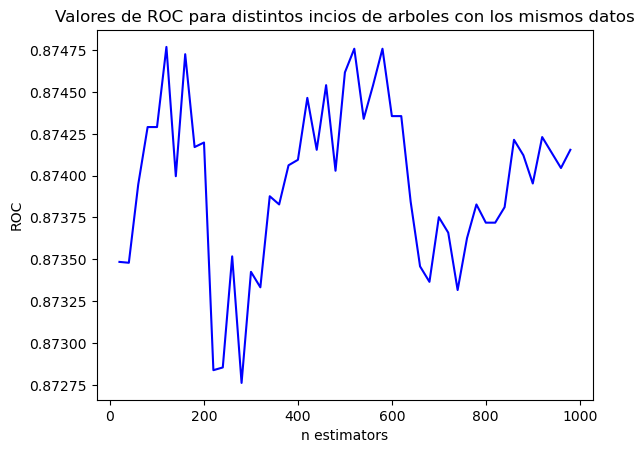

In [ ]:
roc_arr = []
acc_arr = []

n_criterion = ["gini", "entropy", "log_loss"]
n_max_depth = np.arange(10,38, 1)
n_max_features = np.arange(1,12,1)
n_estimators = np.arange(20,1000,20)
# n_estimators = np.arange(80,101,1)

values = n_estimators

for n in values:
    print(n)
    rf = RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "entropy", max_depth=23, max_features=4, n_estimators=120)
    #rf = RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "entropy", max_depth = 27, max_features = 1, n_estimators = 81)
    rf.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)
    y_pred = rf.predict(df_X_test_processed.drop(columns=["score_seller"]))
    roc = roc_auc_score(y_test_transform, y_pred, average='macro')

    roc = roc_auc_score(y_test_transform, y_pred, average='macro')
    acc = accuracy_score(y_test_transform, y_pred)
    roc_arr.append(roc)
    acc_arr.append(acc)


print("max value {}".format(roc_arr[np.argmax(roc_arr)]))
print("max arg {}".format(values[np.argmax(roc_arr)]))
print("max value acc {}".format(acc_arr[np.argmax(acc_arr)]))
print("max arg acc {}".format(values[np.argmax(acc_arr)]))

plt.title('Valores de ROC para distintos incios de arboles con los mismos datos')
plt.plot(values, roc_arr, 'b',)
plt.ylabel('ROC')
plt.xlabel('n estimators')
plt.show()

In [ ]:
RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "entropy", max_depth=23, max_features=4, n_estimators=120)

In [ ]:
n_criterion = ["gini", "entropy", "log_loss"]
n_max_depth = np.arange(21,32, 2)
n_max_features = np.arange(1,6,1)
n_estimators = np.arange(100,130,10)

parameters = {"criterion": n_criterion, 
              "max_depth":n_max_depth,               
              "max_features":n_max_features,
              "n_estimators":n_estimators
              }
clf = GridSearchCV(RandomForestClassifier(random_state=123, n_jobs=-1), parameters, verbose = 3)
clf.fit(df_X_train_processed.drop(columns="score_seller"),y_train_transform)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.906 total time=   3.7s
[CV 2/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.906 total time=   0.7s
[CV 3/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.906 total time=   0.7s
[CV 4/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.909 total time=   0.7s
[CV 5/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=100;, score=0.904 total time=   0.7s
[CV 1/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=110;, score=0.906 total time=   0.8s
[CV 2/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=110;, score=0.906 total time=   0.8s
[CV 3/5] END criterion=gini, max_depth=21, max_features=1, n_estimators=110;, score=0.906 total time=   0.8s
[CV 4/5] END criterion=gini, max_depth=21, max_features=1, n_est

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=123),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([21, 23, 25, 27, 29, 31]),
                         'max_features': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([100, 110, 120])},
             verbose=3)

In [ ]:
print(clf.best_params_)
print(clf.best_score_)

y_pred = clf.best_estimator_.predict(df_X_test_processed.drop(columns="score_seller"))
print(accuracy_score(y_test_transform, y_pred))

{'criterion': 'gini', 'max_depth': 25, 'max_features': 5, 'n_estimators': 110}
0.9123777777777778
0.873


In [ ]:
rf = RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "entropy", max_depth=23, max_features=4, n_estimators=120)

rf.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)
y_pred = rf.predict(df_X_test_processed.drop(columns=["score_seller"]))

roc = roc_auc_score(y_test_transform, y_pred, average='macro')
acc = accuracy_score(y_test_transform, y_pred)
print(roc)
print(acc)

0.874769178089583
0.8754


In [ ]:
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': df_X_train_processed.drop(columns=["score_seller"]).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
importance_df.reset_index(drop=True, inplace=True)
importance_df.head(5)

,Feature,Importance
0,score_popularity_category,0.324591
1,listing_type_id,0.143658
2,initial_quantity,0.093324
3,price,0.084819
4,score_category_id,0.059292


## Stacked

In [ ]:
estimators = [
    ("xg", XGBClassifier(learning_rate=0.61, max_depth=6,n_estimators=100,reg_lambda = 1, reg_alpha= 0)),
    ("rf", RandomForestClassifier(random_state=123, n_jobs=-1, criterion= "entropy", max_depth=23, max_features=4, n_estimators=120))
]

clf = VotingClassifier(estimators=estimators, voting="hard", n_jobs=-1)
#clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=123, n_jobs=-1))
clf.fit(df_X_train_processed.drop(columns=["score_seller"]), y_train_transform)


y_pred = clf.predict(df_X_test_processed.drop(columns=["score_seller"]))
print(roc_auc_score(y_test_transform, y_pred, average='macro'))
print(accuracy_score(y_test_transform, y_pred))

0.8747062833972025
0.8774


## Proposed Metric

F1-score

In [68]:
from sklearn.metrics import f1_score, precision_score

print(f1_score(y_test_transform, y_pred))

0.8631390935476669


In [ ]:
df_X_train_processed.to_csv("df_x_train.csv",index=False)
pd.DataFrame(y_train_transform).to_csv("df_y_train.csv",index=False)
df_X_test_processed.to_csv("df_x_test.csv",index=False)
pd.DataFrame(y_test_transform).to_csv("df_y_test.csv",index=False)